In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 1. 讀檔（請確保能連網），或先手動下載到本地再調整路徑
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)


In [8]:
# 查看欄位
print("欄位：", df.columns.tolist())
print("資料量：", df.shape)

欄位： ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']
資料量： (1462, 9)


In [16]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [17]:
# 2. 檢查缺值並補值
# 先分資料型別：簡單的做法是以 object 類型視為 categorical，其餘視為 numerical
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
print("categorical:", cat_cols)
print("numerical:", num_cols)

# 補值：categorical -> 'NA', numerical -> 0.0
df[cat_cols] = df[cat_cols].fillna('NA')
df[num_cols] = df[num_cols].fillna(0.0)

# 目標欄位
y = df['converted']
# 把 id/time 等非特徵欄位移除（若存在）
# 觀察是否有不需要的欄位（如 'lead_id' 等）—我們保留除 'converted' 以外的所有欄位做 encoding
X = df.drop(columns=['converted'])

# 3. 切資料 60/20/20 using train_test_split twice with random_state=1
# 先切出 temp (80%) 與 test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
# 再把 temp 切成 train(60%) / val(20%) -> 因為 temp 是整體的 80%，要讓 train = 60% -> train size = 0.75 of temp
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp)

print("sizes: train, val, test =", X_train.shape[0], X_val.shape[0], X_test.shape[0])


categorical: ['lead_source', 'industry', 'employment_status', 'location']
numerical: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']
sizes: train, val, test = 876 293 293


In [34]:

# Q1: ROC AUC feature importance for numerical variables
candidates = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_results = {}
for col in candidates:
    if col not in X_train.columns:
        print(f"Warning: {col} not in columns")
        auc_results[col] = None
        continue
    scores = X_train[col].astype(float).values
    # compute AUC; roc_auc_score needs 1D scores and y_train
    try:
        auc = roc_auc_score(y_train, scores)
    except Exception as e:
        # 如果 AUC 計算失敗（e.g., 常數欄位），設為 nan
        auc = np.nan
    # 如果 < 0.5，取 -col 的 AUC（即 1 - auc）或直接計算負分數
    if auc < 0.5:
        auc_inv = roc_auc_score(y_train, -scores)
        auc_results[col] = auc_inv
    else:
        auc_results[col] = auc

print("\nQ1 AUCs (使用 train):")
for k, v in auc_results.items():
    print(k, ":", v)

best_col = max([k for k in auc_results.keys() if auc_results[k] is not None], key=lambda x: auc_results[x])
print("Q1 best numerical feature:", best_col)



Q1 AUCs (使用 train):
lead_score : 0.6177918249741454
number_of_courses_viewed : 0.7519093679314673
interaction_count : 0.7057305924709238
annual_income : 0.5674735508989652
Q1 best numerical feature: number_of_courses_viewed


In [35]:

# Q2: One-hot with DictVectorizer + LogisticRegression
# Prepare DictVectorizer on train
dv = DictVectorizer(sparse=False)
train_dicts = X_train.to_dict(orient='records')
X_train_pr = dv.fit_transform(train_dicts)
val_dicts = X_val.to_dict(orient='records')
X_val_pr = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_pr, y_train)
y_val_pred_proba = model.predict_proba(X_val_pr)[:, 1]
auc_val = roc_auc_score(y_val, y_val_pred_proba)
print("\nQ2 validation AUC (rounded 3 digits):", round(auc_val, 3))




Q2 validation AUC (rounded 3 digits): 0.9


Q3: Precision and Recall intersect at threshold ≈ 0.620


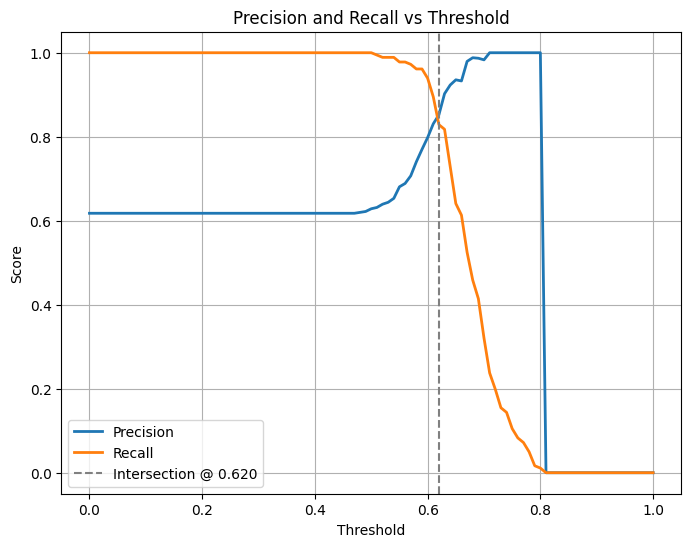

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Q3: Precision & Recall vs Threshold

# 建立 thresholds 從 0 到 1（步長 0.01）
thresholds = np.arange(0.0, 1.001, 0.01)
precisions = []
recalls = []

# 計算每個 threshold 對應的 precision / recall
for t in thresholds:
    preds = (y_val_pred_proba >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds, zero_division=0)
    precisions.append(p)
    recalls.append(r)

# 轉為 numpy array
precisions = np.array(precisions)
recalls = np.array(recalls)

# 過濾掉 precision + recall 全部為 0 的 threshold（避免無意義值影響交點）
valid_idx = (precisions + recalls) > 0
thresholds_valid = thresholds[valid_idx]
precisions_valid = precisions[valid_idx]
recalls_valid = recalls[valid_idx]

# 找出 precision 與 recall 最接近的 threshold
diff = np.abs(precisions_valid - recalls_valid)
idx_min = diff.argmin()
threshold_intersection = thresholds_valid[idx_min]

print(f"Q3: Precision and Recall intersect at threshold ≈ {threshold_intersection:.3f}")

# 繪圖
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.axvline(threshold_intersection, color='gray', linestyle='--', label=f'Intersection @ {threshold_intersection:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [41]:

# Q4: F1 across thresholds
f1s = []
for t in thresholds:
    preds = (y_val_pred_proba >= t).astype(int)
    f1s.append(f1_score(y_val, preds, zero_division=0))
f1s = np.array(f1s)
idx_max_f1 = f1s.argmax()
threshold_max_f1 = thresholds[idx_max_f1]
print(f"Q4 threshold where F1 is maximal: {threshold_max_f1:.3f}")


Q4 threshold where F1 is maximal: 0.600


In [33]:

# Q5: 5-Fold CV on df_full_train (which is X_temp/y_temp or the 80% data)
# The instruction said df_full_train: that's usually the full training set before we split off the test.
df_full_train = pd.concat([X_temp, y_temp], axis=1)
# Prepare features & target
X_full = df_full_train.drop(columns=['converted'])
y_full = df_full_train['converted']

# We'll use dv (but we need to fit dv inside each fold using train of that fold)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []
for train_idx, val_idx in kf.split(X_full):
    Xtr = X_full.iloc[train_idx]
    Xvl = X_full.iloc[val_idx]
    ytr = y_full.iloc[train_idx]
    yvl = y_full.iloc[val_idx]

    dv_fold = DictVectorizer(sparse=False)
    Xtr_pr = dv_fold.fit_transform(Xtr.to_dict(orient='records'))
    Xvl_pr = dv_fold.transform(Xvl.to_dict(orient='records'))

    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(Xtr_pr, ytr)
    yvl_pred = model_fold.predict_proba(Xvl_pr)[:, 1]
    auc_fold = roc_auc_score(yvl, yvl_pred)
    aucs.append(auc_fold)

aucs = np.array(aucs)
print("\nQ5 5-fold AUCs:", aucs)
print("Q5 mean AUC:", aucs.mean(), "std AUC:", aucs.std())



Q5 5-fold AUCs: [0.80125302 0.83748443 0.86160714 0.77801587 0.8060946 ]
Q5 mean AUC: 0.8168910142722202 std AUC: 0.029312137624452266


In [29]:

# Q6: Hyperparameter tuning for C in [1e-6, 1e-3, 1] using same KFold
C_values = [1e-6, 1e-3, 1.0]
results = {}
for C in C_values:
    aucs_c = []
    for train_idx, val_idx in kf.split(X_full):
        Xtr = X_full.iloc[train_idx]
        Xvl = X_full.iloc[val_idx]
        ytr = y_full.iloc[train_idx]
        yvl = y_full.iloc[val_idx]

        dv_fold = DictVectorizer(sparse=False)
        Xtr_pr = dv_fold.fit_transform(Xtr.to_dict(orient='records'))
        Xvl_pr = dv_fold.transform(Xvl.to_dict(orient='records'))

        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(Xtr_pr, ytr)
        yvl_pred = model_fold.predict_proba(Xvl_pr)[:, 1]
        auc_fold = roc_auc_score(yvl, yvl_pred)
        aucs_c.append(auc_fold)
    aucs_c = np.array(aucs_c)
    results[C] = (aucs_c.mean(), aucs_c.std())

print("\nQ6 results (mean, std) for each C (rounded 3 digits):")
for C, (m, s) in results.items():
    print(C, round(m,3), round(s,3))

# Select best C according to rules
# 1) highest mean, 2) if tie -> lowest std, 3) if tie -> smallest C
best = None
for C, (m, s) in results.items():
    if best is None:
        best = (C, m, s)
    else:
        if np.isclose(m, best[1], atol=1e-9):
            # tie on mean -> pick lower std
            if s < best[2] - 1e-12:
                best = (C, m, s)
            elif np.isclose(s, best[2], atol=1e-12):
                # tie on std as well -> pick smaller C
                if C < best[0]:
                    best = (C, m, s)
        elif m > best[1]:
            best = (C, m, s)

print("\nSelected best C:", best[0], "mean:", round(best[1],3), "std:", round(best[2],3))



Q6 results (mean, std) for each C (rounded 3 digits):
1e-06 0.561 0.035
0.001 0.86 0.026
1.0 0.817 0.029

Selected best C: 0.001 mean: 0.86 std: 0.026
